# Klasifikacija mina i kamenja u sonar datasetu 

### Autori: Alen Andrašek, Monika Majstorović, Luka Valenta 

Ovaj notebook napravljen je za potrebe kolegija Strojno učenje na PMF-u Sveučilišta u Zagrebu kao realizacija projektnog zadatka u akademskoj godini 2017./2018. 

Mentori:
- Tomislav Šmuc, prof.
- Tomislav Lipić, asist.
- Matija Piškorec, asist.

Cilj ovog notebooka jest pokazati primjer metodologije pri odabiru modela, obradi podataka i općenito realizaciji projekta. Bit će koncipiran kao tutorijal za provedbu projekta "od nule" (tj. počevši od dataseta).

Dataset kojeg koristimo naziva se Connectionist Bench (Sonar, Mines vs. Rocks) Data Set (skraćeno: sonar dataset) i skinut je s UCI repozitorija za strojno učenje.

##  1. O datasetu

Prvo pitanje koje si postavljamo kada pred sobom imamo dataset jest: koji problem rješavamo pomoću ovog dataseta?

U opisu sonar dataseta dostupnom na [ref] saznajemo da je za svaki uzorak u datasetu poznato radi li se o mini ili kamenu te da je zadatak klasifikacija podataka u te dvije skupine.
Dakle, radi se o **nadziranom učenju** i problemu **binarne klasifikacije**.

Kako izgleda dataset?

Iz [ref] također saznajemo da dataset sadrži 208 podataka. Svaki od njih ima 60 značajki čije su vrijednosti između 0.0 i 1.0 te oznaku klase 'R' ili 'M' ovisno o tome pripada li podatak kamenu ili mini. Ukupno ima 111 podataka koji pripadaju minama i 97 koji pripadaju kamenju. Nema vrijednosti koje nedostaju.

Pokažimo kako bismo to ispitali koristeći pandas:

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [57]:
# Učitamo dataset i dodijelimo imena stupcima

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data"

colNames = []
for i in range(60):
    colNames.append(i+1)
colNames.append("Class")

sonar = pd.read_csv(url,names=colNames,header=None)
sonar.head()

,1,2,3,4,5,6,7,8,9,10,...,52,53,54,55,56,57,58,59,60,Class
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [58]:
sonar.shape  # Dataframe ima 208 redaka i 61 stupac.

(208, 61)

In [59]:
sonar.dtypes.head()  #Tipovi podataka u dataframeu.

1    float64
2    float64
3    float64
4    float64
5    float64
dtype: object

In [60]:
sonar.groupby('Class').size()  # Želimo saznati koliko ima podataka određene klase.

Class
M    111
R     97
dtype: int64

In [61]:
sonar.isnull().any().any()  # Ima li vrijednosti koje nedostaju?

False

Sonar dataset je mali. Kod malih datasetova veći problem nego kod velikih datasetova mogu prestavljati:
-  vrijednosti koje nedostaju
-  buka
-  overfitting

Više o načinu pristupa malim datasetovima u strojnom učenju pročitajte u članku [ref].

Već smo pokazali da nema vrijednosti koje nedostaju u sonar datasetu.

Pretpostavljamo da je buka u datasetu minimalna zbog načina prikupljanja i obrade podataka prije nego što su ušli u dataset. Naime, podaci su skupljeni tako što su na pjeskovito morsko dno stavljeni metalni cilindar i kamenje otprilike
cilindričnog oblika, oboje duljine oko 1.52 m (5 ft) te je pomoću sonara emitiran signal. Jeka je prikupljena s udaljenosti 10 m te iz kuteva raspona do 90° za cilindar i raspona do 180° za kamen. **Od 1200 primljenih zvukova, odabrano ih je 208 koji su imali omjer šuma i signala između 4 dB i 15 dB.** Daljnjom spektralnom analizom signala te normalizacijom dobivenih podataka svaki od 208 signala predstavljen je konačno 60-dimenzionalnim vektorom u kojem svaka komponenta poprima vrijednosti između 0.0 i 1.0.

Za rješavanje problema overfittinga preporučuje se odabir jednostavnijih modela poput logističke regresije, k-Nearest Neighbours (k-NN), Support Vector Machine (SVM), Random Forest (dodati još, ne sjećam se). 

Mi smo odabrali SVM i k-NN. Njihov performans na kraju ćemo usporediti.



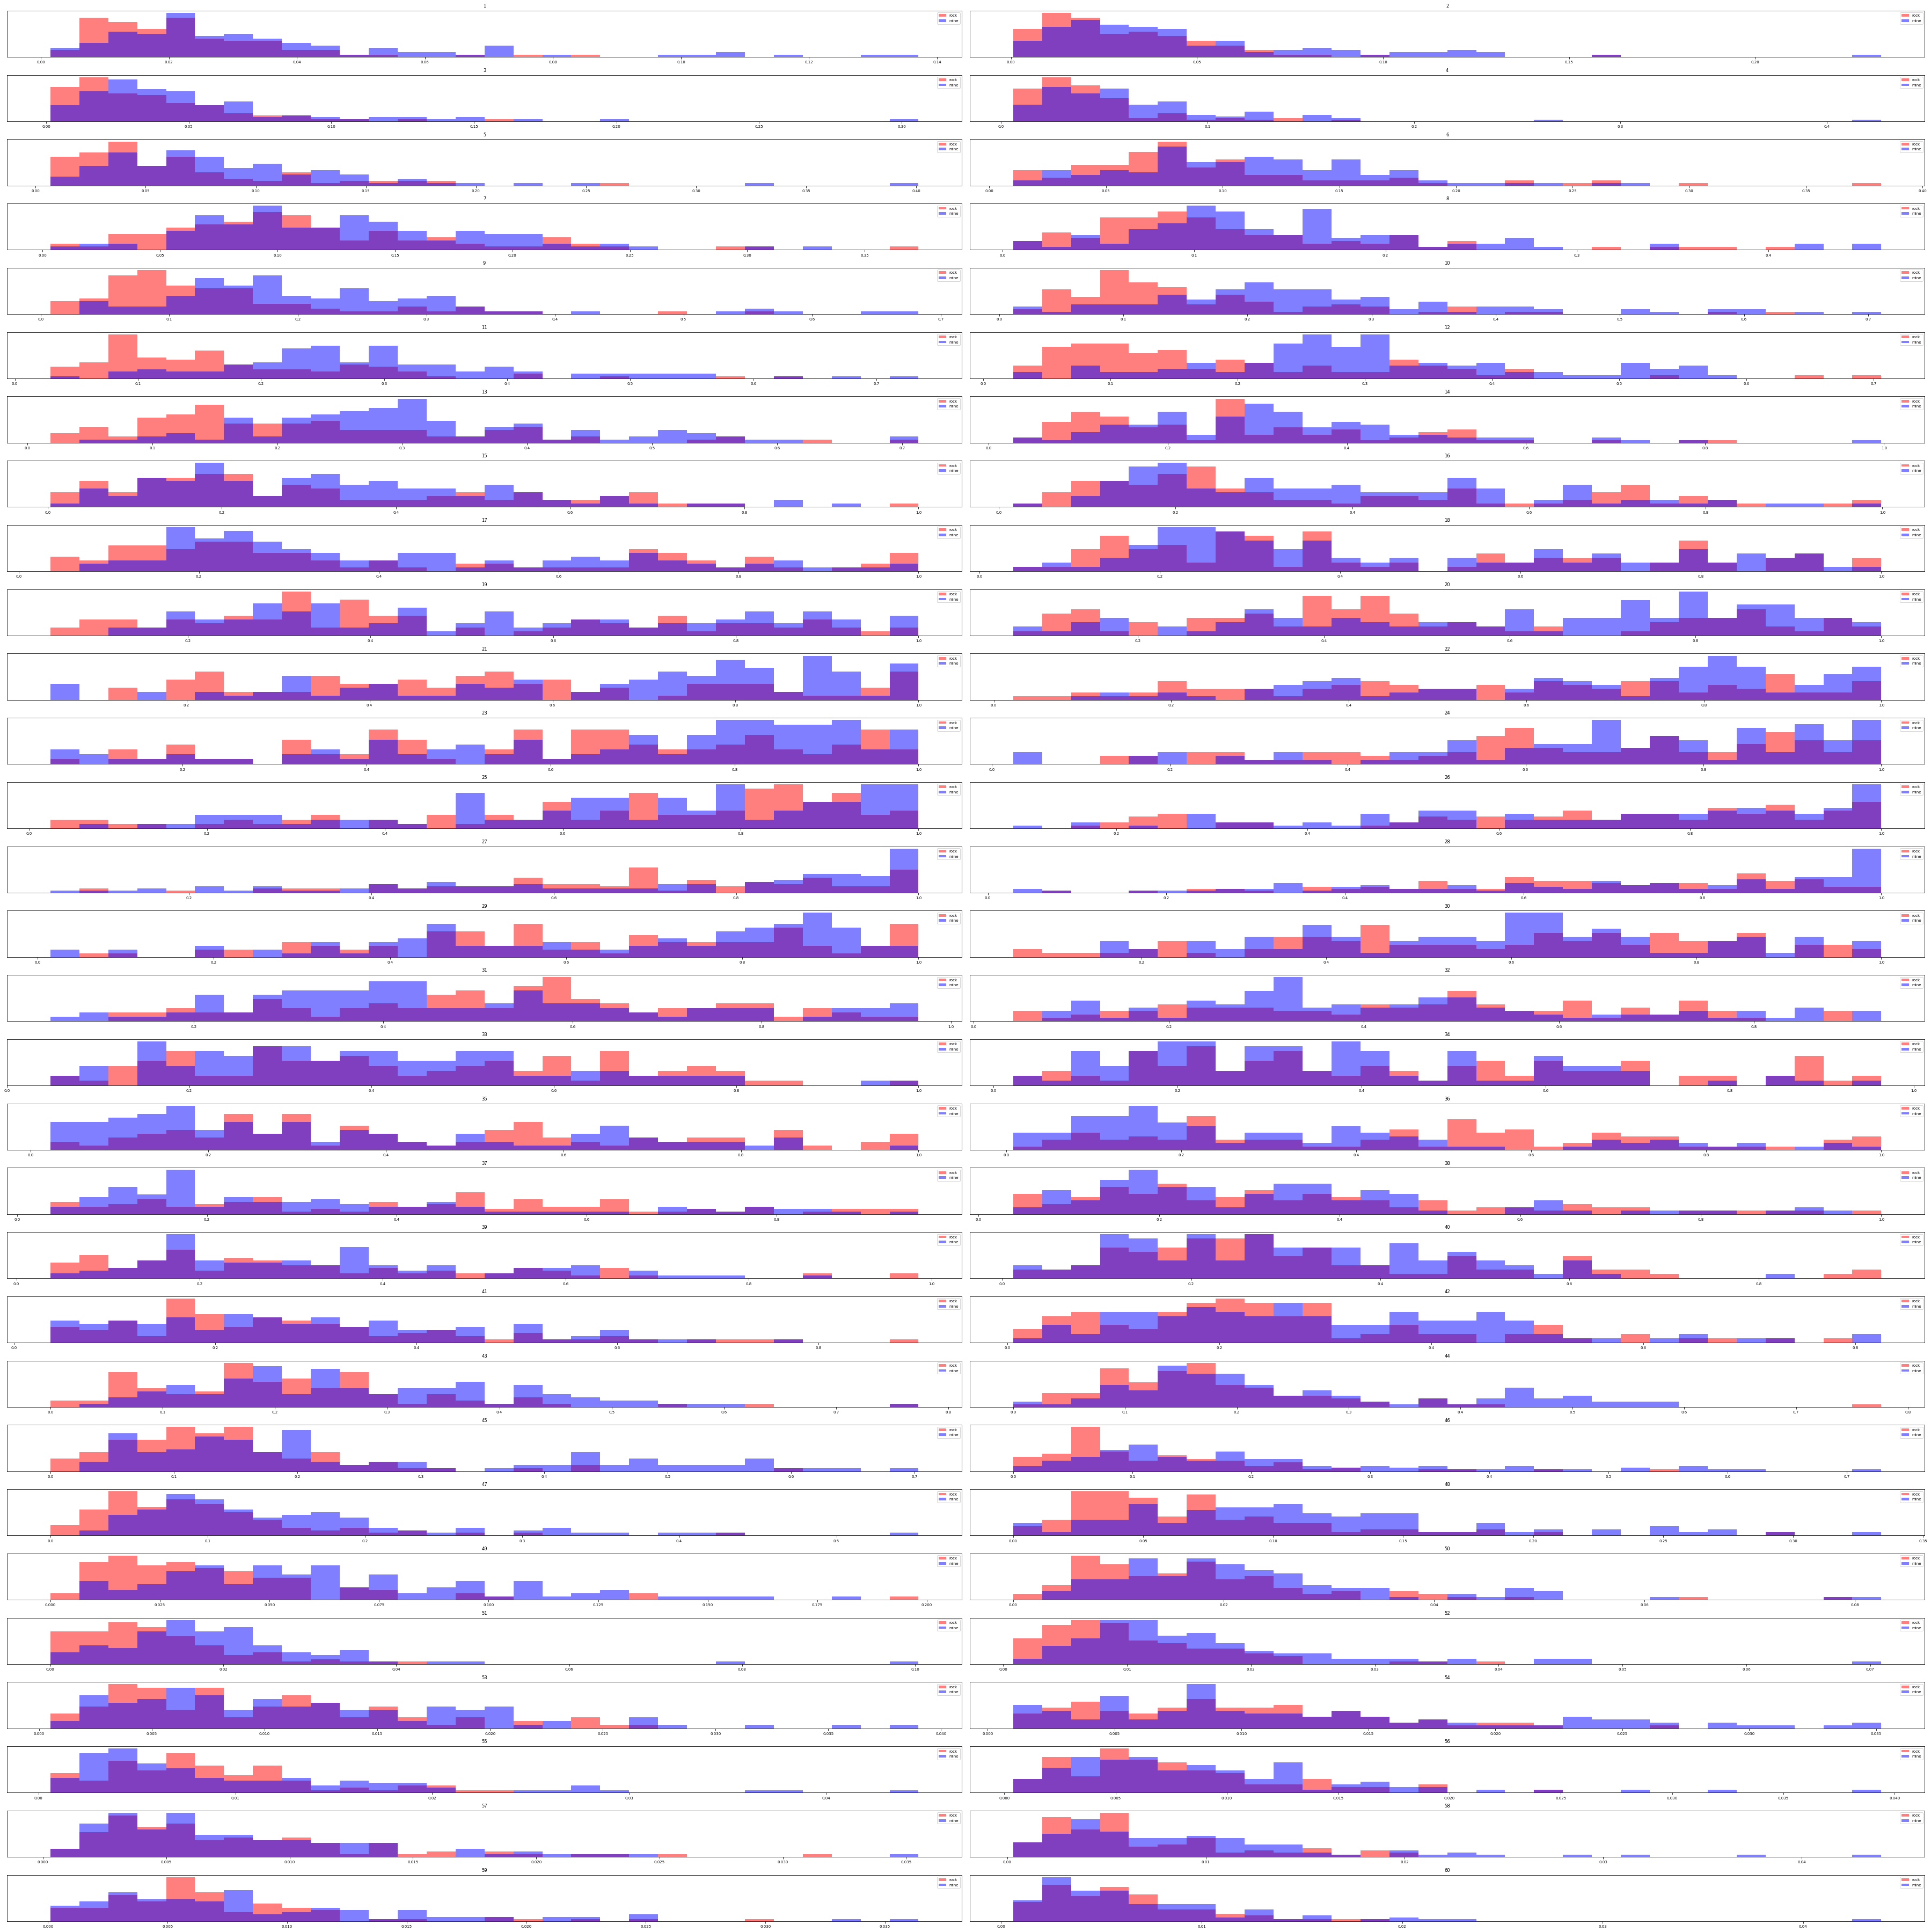

In [62]:
# Koreliranost klasa
rock = sonar.loc[ sonar['Class'] == 'R', : ]
mine = sonar.loc[ sonar['Class'] == 'M', : ]

fig, axes = plt.subplots(30, 2, figsize=(50,50))
ax = axes.ravel() # axes are 2-dimensional so we unfold them
for i in range(60):
    _, bins = np.histogram(sonar.iloc[:,i], bins=30)
    ax[i].hist(rock.iloc[:,i], bins=bins, color='r', alpha=.5, label='rock')
    ax[i].hist(mine.iloc[:,i], bins=bins, color='b', alpha=.5, label='mine')
    ax[i].set_title(sonar.columns.values[i])
    ax[i].set_yticks(()) # remove ticks on y-axis
    ax[i].legend(loc='upper right')
fig.tight_layout();

Nećemo vršiti standardizaciju podataka prije PCA jer su nam podaci istog tipa i u istoj mjernoj jedinici.
[ref = https://www.researchgate.net/post/What_is_the_best_way_to_scale_parameters_before_running_a_Principal_Component_Analysis_PCA]

In [63]:
sonar_y = [] # target array (niz čiji elementi govore je li odgovarajući element tog indexa u datasetu sonar R ili M)
for i in range(97):
    sonar_y.append(0) # 0 označavaju R
for i in range(111):
    sonar_y.append(1) # 1 označavaju M
sonar_y = np.array(sonar_y)

sonar_bez_Class = sonar.drop('Class', axis=1) # uklonimo zadnji stupac Class iz sonar dataframea
sonar_X = np.array(sonar_bez_Class.values)

# sonar_y i sonar_X moraju biti np.array jer fja split prima samo objekte tog tipa

In [73]:
# shuffle
from sklearn.utils import shuffle

random_state = 42
# fiksiranje broja random state omogućuje da svaki put kada opet runamo ovaj kod, dobijemo istu podjelu na subsetove
# ovaj broj kojim fiksiramo odabran je nasumično

X,y = shuffle(sonar_X,sonar_y,random_state=random_state)
print("Target varijabla nakon miješanja: \n", y)

Target varijabla nakon miješanja: 
 [1 0 0 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 1 1
 1 0 1 0 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0 1 1 0 1 0 1 1 1 1 1 0 0 0 0 0 0 1 1
 0 1 1 0 0 1 0 1 0 1 1 1 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 1 0 0 1 1 1 0 0
 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 0 0 1 0 1 0 1 1 0 0 1 0 0 1 0 1 0 1 0 1 1 1
 1 0 0 0 0 1 0 0 1 1 0 0 0 0 1 1 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 0 0 1 1 1
 0 1 1 0 0 1 1 1 1 1 1 0 0 1 1 0 1 0 1 0 0 1 1]


## 2. PCA

In [40]:
from sklearn.decomposition import PCA

In [52]:
#PCA

pca = PCA(.95) #  Zadržat ćemo 95% varijance (95% se inače uzima, mi se možemo dogovoriti i za manji broj)
brojKomponenti = [] # Usput ćemo i bilježiti koliko komponenti smo uzeli za svaki skup, tj. kolika nam je sada dimenz.

pca.fit(X)
brojKomponenti = pca.n_components_
X = pca.transform(X)

print("Broj dimenzija nakon PCA: ", brojKomponenti)

NameError: name 'X' is not defined

In [42]:
from sklearn.model_selection import RepeatedStratifiedKFold

random_state = 164981614

rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=random_state)

X_train, X_test, y_train, y_test = [], [], [], []

for train_index, test_index in rskf.split(X, y):
    X_train.append(X[train_index])
    X_test.append(X[test_index])
    y_train.append(y[train_index])
    y_test.append(y[test_index])

In [43]:
print("Veličina prvog train seta: ", len(X_train[0]))
print("Veličina prvog test seta: ", len(X_test[0]))
print(len(X_train[0]), "+", len(X_test[0]), "=", len(X_train[0])+len(X_test[0]))

Veličina prvog train seta:  186
Veličina prvog test seta:  22
186 + 22 = 208


## 3. SVM

In [44]:
# SVM

from time import time
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV  # In new version (0.19. it's in model_selection module!)
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy import stats

### 3.1. SVM koristeći GridSearchCV

In [18]:
pipeline = Pipeline( [ ('SVM', svm.SVC(kernel='rbf',probability=True)) ] )

parameters = {
    #'SVM__C':(1.0,10.0,100.0,1000.0),
    #'SVM__gamma':(0.001,0.01,0.1,1.0)
    'SVM__C': np.logspace(-1, 3, 100),
    'SVM__gamma': np.linspace(0.0001, 10, 100)
}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected block
    grid_search = GridSearchCV(pipeline, parameters, cv=3)
    # default scoring je accuracy koji mi želimo

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(parameters)
    t0 = time()
    rjecnik = {}
    acc = []
    
    
    for i in range(10):
        grid_search.fit(X_train[i], y_train[i])
        best_parameters = grid_search.best_estimator_.get_params()
        model = grid_search.best_estimator_.fit(X_train[i], y_train[i])
        y_pred = model.predict(X_test[i])
        acc_score = accuracy_score(y_test[i],y_pred)
        acc.append(acc_score)
        conf_mat = confusion_matrix(y_test[i],y_pred)
        rjecnik[i+1] = (grid_search.best_score_, best_parameters['SVM__C'], best_parameters['SVM__gamma'], acc_score,
                       conf_mat[1][1], conf_mat[0][1], conf_mat[1][0], conf_mat[0][0])
        
        
    print("done in %0.3fs" % (time() - t0))

Performing grid search...
pipeline: ['SVM']
parameters:
{'SVM__C': array([  1.00000000e-01,   1.09749877e-01,   1.20450354e-01,
         1.32194115e-01,   1.45082878e-01,   1.59228279e-01,
         1.74752840e-01,   1.91791026e-01,   2.10490414e-01,
         2.31012970e-01,   2.53536449e-01,   2.78255940e-01,
         3.05385551e-01,   3.35160265e-01,   3.67837977e-01,
         4.03701726e-01,   4.43062146e-01,   4.86260158e-01,
         5.33669923e-01,   5.85702082e-01,   6.42807312e-01,
         7.05480231e-01,   7.74263683e-01,   8.49753436e-01,
         9.32603347e-01,   1.02353102e+00,   1.12332403e+00,
         1.23284674e+00,   1.35304777e+00,   1.48496826e+00,
         1.62975083e+00,   1.78864953e+00,   1.96304065e+00,
         2.15443469e+00,   2.36448941e+00,   2.59502421e+00,
         2.84803587e+00,   3.12571585e+00,   3.43046929e+00,
         3.76493581e+00,   4.13201240e+00,   4.53487851e+00,
         4.97702356e+00,   5.46227722e+00,   5.99484250e+00,
         6.5793322

In [20]:
print("Parametri dobiveni koristeći GridSearchCV:\n")
df = pd.DataFrame(rjecnik, index=['score', 'C', 'gamma', 'accuracy', 'TP', 'FP', 'FN', 'TN'])
print(df)
    
avg_accuracy = np.average(acc)
print("\nProsječna točnost SVM-a s rbf kernelom i parametrima dobivenim koristeći GridSearchCV je:\n", 
      avg_accuracy*100, "%.")

Parametri dobiveni koristeći GridSearchCV:

                 1          2         3          4          5          6   \
score      0.881720   0.887701  0.898396   0.887701   0.882353   0.877005   
C          2.364489   1.484968  2.154435   1.484968   2.364489   1.963041   
gamma      1.212209   1.414227  1.515236   1.919273   0.707164   0.505145   
accuracy   0.909091   0.761905  0.857143   0.857143   0.857143   0.904762   
TP         9.000000   6.000000  9.000000   7.000000   7.000000  10.000000   
FP         1.000000   4.000000  1.000000   3.000000   3.000000   0.000000   
FN         1.000000   1.000000  2.000000   0.000000   0.000000   2.000000   
TN        11.000000  10.000000  9.000000  11.000000  11.000000   9.000000   

                7          8         9         10  
score     0.903743   0.898936  0.877660  0.904255  
C         5.462277   2.364489  7.924829  4.132012  
gamma     1.313218   1.010191  0.202118  1.111200  
accuracy  0.761905   0.900000  0.850000  0.800000  
TP

### 3.1. SVM koristeći RandomizedSearchCV

In [45]:
pipeline = Pipeline( [ ('SVM', svm.SVC(kernel='rbf',probability=True)) ] )

parameters = {
    'SVM__C':stats.uniform(1, 100),
    'SVM__gamma':stats.uniform(0.001, 1.0)
}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected block
    # default scoring je accuracy koji mi želimo
    randomized_search = RandomizedSearchCV(pipeline, parameters, n_iter=100, random_state=2018, cv=3)
    
    print("Performing randomized search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    t0 = time()
    rjecnik = {}
    acc = []
    for i in range(10):
        randomized_search.fit(X_train[i], y_train[i])
        best_parameters = randomized_search.best_estimator_.get_params() 
        model = randomized_search.best_estimator_.fit(X_train[i], y_train[i])
        y_pred = model.predict(X_test[i])
        acc_score = accuracy_score(y_test[i],y_pred)
        acc.append(acc_score)
        conf_mat = confusion_matrix(y_test[i],y_pred)
        rjecnik[i+1] = (randomized_search.best_score_, best_parameters['SVM__C'], best_parameters['SVM__gamma'], acc_score,
                        conf_mat[1][1], conf_mat[0][1], conf_mat[1][0], conf_mat[0][0])
        
    print("done in %0.3fs" % (time() - t0))

Performing randomized search...
pipeline: ['SVM']
done in 25.858s


In [46]:
print("Parametri dobiveni koristeći RandomizedSearchCV:\n")
df = pd.DataFrame(rjecnik, index=['score', 'C', 'gamma', 'accuracy', 'TP', 'FP', 'FN', 'TN'])
print(df)
    
avg_accuracy = np.average(acc)
print("\nProsječna točnost SVM-a s rbf kernelom i parametrima dobivenim koristeći RandomizedSearchCV je:\n", 
      avg_accuracy*100, "%.")

Parametri dobiveni koristeći RandomizedSearchCV:

                 1          2          3          4          5          6   \
score      0.865591   0.871658   0.877005   0.887701   0.871658   0.871658   
C         84.711110  14.739854  26.269136  42.686251  18.684085  76.709253   
gamma      0.698801   0.691222   0.558125   0.172810   0.580103   1.000671   
accuracy   0.954545   0.857143   0.904762   0.761905   0.952381   0.904762   
TP        10.000000   7.000000   9.000000   7.000000   9.000000   9.000000   
FP         0.000000   3.000000   1.000000   3.000000   1.000000   1.000000   
FN         1.000000   0.000000   1.000000   2.000000   0.000000   1.000000   
TN        11.000000  11.000000  10.000000   9.000000  11.000000  10.000000   

                 7          8          9          10  
score      0.893048   0.904255   0.867021   0.893617  
C         76.709253  88.424103  88.424103  76.709253  
gamma      1.000671   0.482205   0.482205   1.000671  
accuracy   0.761905   0.850

## 4. k-NN

_k Nearest Neighbor_ prima neki training set i za nove podatke određuje većinskim glasovanjem kojoj klasi pripadaju, ovisno o tome kojeg tipa je _k najbližih susjeda_. Metrika može biti bilo koja, ali uobičajena je neka od: Euklidska $(L^2)$, Manhattan $(L^1)$ i Čebišev $(L^\infty)$.

#### funkcija za crtanje heatmap
Ovo je pomoćna funkcija za iscrtavanje GridSearch-a.

In [7]:
# iz mg_learn biblioteke, Andreas Müller
%matplotlib inline

def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(0.707)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img

In [8]:
#učitajmo sve što nam treba - ovo može i obrisati kasnije, radi lakšeg pokretanja donjeg kôda sam ovo stavio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Učitamo dataset i dodijelimo imena stupcima
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data"
sonar = pd.read_csv(url,header=None)
sonar_bez_Class = sonar.drop(60, axis=1) # uklonimo zadnji stupac Class iz sonar dataframea
sonar_X = np.array(sonar_bez_Class.values)
sonar_y = np.array(sonar[60]) # zadnji stupac u kojem je y

#parametar k biramo iz 1...10, i promatramo 3 metrike
param_grid = {'n_neighbors': list(range(1,11)),
              'metric': ['chebyshev', 'euclidean', 'manhattan']}
print("Parameter grid:\n{}".format(param_grid))

Parameter grid:
{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'metric': ['chebyshev', 'euclidean', 'manhattan']}


In [9]:
def grid_search_table():
    #rezultate spremimo u pandas dataframe
    results = pd.DataFrame(grid_search.cv_results_)

    scores = np.array(results.mean_test_score).reshape(3, 10)
    # iscrtamo tablicu vrijednosti kros-validacije
    heatmap(scores, xlabel='n_neighbors', xticklabels=param_grid['n_neighbors'],
                          ylabel='metric', yticklabels=param_grid['metric'], cmap="viridis")

Pokušajmo prvo običan gridsearch za određivanje koji bi paramater _k_ uz koju metriku bio prikladan.

grid_search vraća model s najboljim parametrima - na njemu izračunamo score na testnom skupu.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(sonar_X, sonar_y, random_state=0)

# inicijalizira GridSearch s k-NN klafikatorom s uniformnom težinom
grid_search = GridSearchCV(KNeighborsClassifier(weights='uniform'), param_grid, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)

print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

Test set score: 0.81


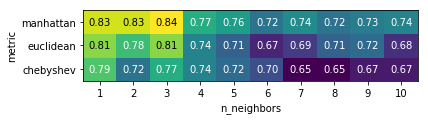

In [11]:
# pojedini mean_test_score u gridsearch - ovi rezultati su dobiveni kros-validacijom na training skupu za pojedine parametre
grid_search_table()

Vidimo da je mali _k_ za ovaj dataset prikladniji od velikog. Također Manhattan udaljenost izgleda prikladna. _k-NN_ algoritam računa udaljenosti i očito je osjetljiv na veličinu ulaza. Iako su ovdje parameteri svi jednake skale, možemo svejedno pokušati __normalizirati__ podatke:

In [12]:
X_train, X_test, y_train, y_test = train_test_split(sonar_X, sonar_y, random_state=0)

# skaliranje podataka
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
scaler.fit(X_train) # nauči transformaciju na training setu
X_train = scaler.transform(X_train) # primijeni transformaciju

# inicijalizira GridSearch validator s k-NN klafikatorom s uniformnom težinom
grid_search = GridSearchCV(KNeighborsClassifier(weights='uniform'), param_grid, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)

X_test_scaled = scaler.transform(X_test)
print("Test set score: {:.2f}".format(grid_search.score(X_test_scaled, y_test)))

Test set score: 0.85


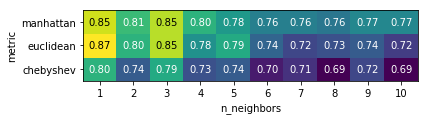

In [15]:
grid_search_table()

Grid search vraća model čiji su parametri postigli najbolje rezultate u kros-validaciji.
Ovdje bi grid_search vratio 1-NN model s Euklidskom udaljenosti.

Vidimo da se je sada stvar okrenula i da se euklidska udaljenost čini nešto prikladnija.
Kao što vidimo gore, na (unaprijed izdvojenom) testnom skupu model postiže točnost 85%.

Što ako normaliziramo train i test skup odvojeno? Ovo nema smisla jer će se primijeniti _različite_ transformacije na test i training set!

In [16]:
# normaliziraj X_test - ovo će transformirati podatke drugačije od X_train
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
X_test_scaled = scaler.fit_transform(X_test) 
print("Test set score: {:.2f}".format(grid_search.score(X_test_scaled, y_test)))

Test set score: 0.88


Ironično, točnost je ispala veća. Ipak, ovo __nije__ valjana metoda i nema smisla.

Primijetimo da transformiramo prvo training set, i onda za provjeru test set transformiramo istom transformacijom kasnije.
Ali u GridSearchCV šaljemo već normalizirani skup. To znači da validacijski skupovi su već unaprijed transformirani zajedno s training setom. Zato možemo napraviti pipeline od skaliranja i klasifikatora:

__Ne radi za sada, smisliti još, ili izbaciti__

In [17]:
X_train, X_test, y_train, y_test = train_test_split(sonar_X, sonar_y, random_state=0)

# klasifikator
from sklearn.pipeline import make_pipeline
grid_search = GridSearchCV(make_pipeline(StandardScaler(), 
                           KNeighborsClassifier(weights='uniform')), 
                           param_grid, cv=5, 
                           return_train_score=True)


Pokušajmo smanjiti dimenzionalnost s PCA:

Test set score: 0.81


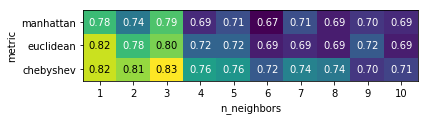

In [21]:
from sklearn.decomposition import PCA

sonar_PCA = PCA(0.95).fit_transform(sonar_X)
X_train, X_test, y_train, y_test = train_test_split(sonar_PCA, sonar_y, random_state=0)

grid_search = GridSearchCV(KNeighborsClassifier(weights='uniform'), 
                           param_grid, cv=5, 
                           return_train_score=True)
grid_search.fit(X_train, y_train)

import pandas as pd
results = pd.DataFrame(grid_search.cv_results_)

print("Test set score: {:.2f}".format(grid_search.score(X_test,y_test)))

grid_search_table()

Sada pak se najbolja metrika čini Čebiševljevom.

Na kraju, možemo pokušati i s _težinskim_ k-NN algoritmom. U klasifikator stavimo parametar _weights_='distance'.

U ovoj varijanti bliži susjedi imaju jači utjecaj (npr. za 3-NN, jedan jako bliski susjed, može nadjačati druga dva).

Test set score: 0.85


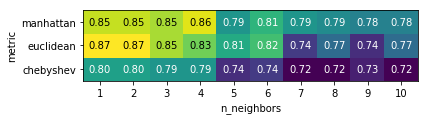

In [22]:
X_train, X_test, y_train, y_test = train_test_split(sonar_X, sonar_y, random_state=0)

#skaliranje podataka
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

# inicijalizira GridSearch validator s k-NN klafikatorom s različitim težinama susjeda
grid_search = GridSearchCV(KNeighborsClassifier(weights='distance'), param_grid, cv=5, return_train_score=True)
grid_search.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test)
print("Test set score: {:.2f}".format(grid_search.score(X_test_scaled, y_test)))

grid_search_table()

Vidimo da su rezultati nešto robustniji za različite _k_.

E sad možda koji bagged k-NN. Još neka tablica itd.

**Pokušaji automatskog cross-validation**

In [23]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(GridSearchCV(KNeighborsClassifier(weights='distance'), param_grid, cv=10, return_train_score=True),
                         sonar_X, sonar_y, cv=10)
print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [ 0.59090909  0.76190476  0.80952381  0.61904762  0.47619048  0.52380952
  0.71428571  0.85        0.6         0.8       ]
Mean cross-validation score:  0.674567099567


In [24]:
# Učitamo dataset i dodijelimo imena stupcima
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data"
sonar = pd.read_csv(url,header=None)
sonar_bez_Class = sonar.drop(60, axis=1) # uklonimo zadnji stupac Class iz sonar dataframea
sonar_X = np.array(sonar_bez_Class.values)
sonar_y = np.array(sonar[60]) # zadnji stupac u kojem je y

from sklearn.model_selection import cross_val_score
scores = cross_val_score(GridSearchCV(KNeighborsClassifier(weights='distance'), 
                                      param_grid, 
                                      cv=10),
                         sonar_X, sonar_y, cv=10)
print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [ 0.59090909  0.76190476  0.80952381  0.61904762  0.47619048  0.52380952
  0.71428571  0.85        0.6         0.8       ]
Mean cross-validation score:  0.674567099567


In [25]:
# Učitamo dataset i dodijelimo imena stupcima
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data"
sonar = pd.read_csv(url,header=None)
sonar_bez_Class = sonar.drop(60, axis=1) # uklonimo zadnji stupac Class iz sonar dataframea
sonar_X = np.array(sonar_bez_Class.values)
sonar_y = np.array(sonar[60]) # zadnji stupac u kojem je y

X_train, X_test, y_train, y_test = train_test_split(sonar_X, sonar_y, random_state=0, stratify=sonar_y)

grid_search = GridSearchCV(KNeighborsClassifier(weights='distance'), 
                                      param_grid, 
                                      cv=10)
grid_search.fit(X_train, y_train)
print("Results: ", grid_search.score(X_test, y_test))

Results:  0.865384615385


**Ručni nested cross-validation**

In [74]:
param_grid = {'n_neighbors': list(range(1,11)),
              'metric': ['chebyshev', 'euclidean', 'manhattan']}

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, random_state=2018)

X_train, X_test, y_train, y_test = [], [], [], []
# možda će ih trebati pretvoriti u numpy array kasnije, ne znam

for train_index, test_index in skf.split(X, y):
    X_train.append(X[train_index])
    X_test.append(X[test_index])
    y_train.append(y[train_index])
    y_test.append(y[test_index])
    
grid_search = GridSearchCV(KNeighborsClassifier(weights='distance'), param_grid, cv=10)

rjecnik = {}
acc = []
for i in range(10):
        grid_search.fit(X_train[i], y_train[i])
        best_parameters = grid_search.best_estimator_.get_params()
        rjecnik[i+1] = (grid_search.best_score_, best_parameters['n_neighbors'], best_parameters['metric'])
        
        model = grid_search.best_estimator_.fit(X_train[i], y_train[i])
        '''y_pred = model.predict(X_test[i])
        acc_score = accuracy_score(y_test[i],y_pred)
        acc.append(acc_score)'''
        # može i ovako
        acc_score = model.score(X_test[i], y_test[i])
        acc.append(acc_score)
        
        rjecnik[i+1] = (grid_search.best_score_, best_parameters['n_neighbors'], best_parameters['metric'], acc_score)

In [75]:
print("Parametri dobiveni koristeći GridSearchCV:\n")
df = pd.DataFrame(rjecnik, index=['score', 'n_neighbors', 'metric', 'accuracy'])
print(df.round(2))

print(acc)
avg_accuracy = np.average(acc)
print("\nProsječna točnost k-NN-a s rbf kernelom i parametrima dobivenim koristeći GridSearchCV je:\n", 
      avg_accuracy*100, "%.")

Parametri dobiveni koristeći GridSearchCV:

                    1          2          3          4          5          6   \
score         0.844086    0.84492   0.860963   0.855615   0.855615   0.855615   
n_neighbors          6          1          1          1          5          5   
metric       manhattan  manhattan  manhattan  manhattan  manhattan  manhattan   
accuracy      0.954545   0.952381   0.904762   0.761905   0.761905   0.809524   

                    7          8          9          10  
score         0.839572   0.861702   0.835106   0.845745  
n_neighbors          1          1          1          1  
metric       manhattan  manhattan  manhattan  manhattan  
accuracy      0.857143        0.8       0.95       0.95  
[0.95454545454545459, 0.95238095238095233, 0.90476190476190477, 0.76190476190476186, 0.76190476190476186, 0.80952380952380953, 0.8571428571428571, 0.80000000000000004, 0.94999999999999996, 0.94999999999999996]

Prosječna točnost k-NN-a s rbf kernelom i paramet

## Random Forest

Glavni parametar u RandomForest je broj stabala *n_estimators* i broj korištenih feature-a u svakom stablu *max_features*.

Učitamo sve što nam treba (ili ne moramo ako smo već pokrenuli gore) i ovaj put uzmemo Random Forest klasifikator.

In [40]:
import pandas as pd
from time import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

# Učitamo dataset i dodijelimo imena stupcima
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data"
sonar = pd.read_csv(url,header=None)
sonar_bez_Class = sonar.drop(60, axis=1) # uklonimo zadnji stupac Class iz sonar dataframea
sonar_X = np.array(sonar_bez_Class.values)
sonar_y = np.array(sonar[60]) # zadnji stupac u kojem je y

# biramo broj stabala odlučivanja u šumi te broj značajki koje će Random Forest algoritam koristiti
param_grid = {'n_estimators': list(range(1,21,2)),
              'max_features': list(range(1,10))+list(range(10,61,5))}
print("Parameter grid:\n{}".format(param_grid))

def grid_search_table_RF():
    # povećaj sliku, smanji font
    plt.figure(dpi=150)
    plt.rc('text', fontsize=7)
    
    #rezultate spremimo u pandas dataframe
    results = pd.DataFrame(grid_search.cv_results_)

    scores = np.array(results.mean_test_score).reshape(10, 20)
    # plot the mean cross-validation scores
    heatmap(scores, ylabel='n_estimators', yticklabels=param_grid['n_estimators'],
                          xlabel='max_features', xticklabels=param_grid['max_features'], cmap="viridis")

Parameter grid:
{'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60], 'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]}


Opet, koristimo GridSearch zajedno s vanjskom kros-validacijom.

In [46]:
X_train, X_test, y_train, y_test = train_test_split(sonar_X, sonar_y, random_state=0)
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, return_train_score=True)
t0 = time()
grid_search.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))

done in 35.150s


Primijetimo da GridSearch za random forest klasfiikator traje znatno duže nego za k-NN (što je i za očekivati kako je random forest sâm kombinacija više klasifikatora). Sada napravimo heatmap od grid searcha.

Test set score: 0.73


C:\Users\Alen\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\matplotlib\__init__.py:913: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


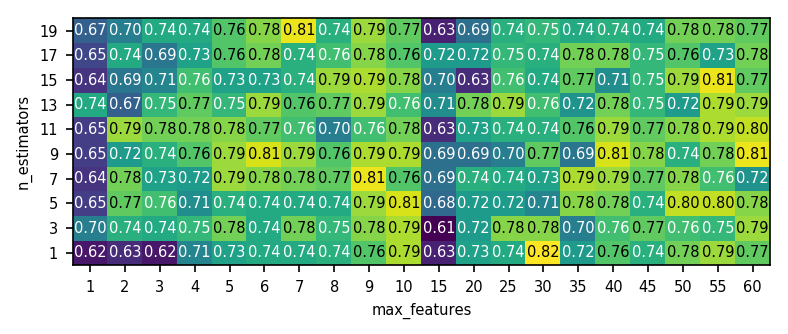

In [42]:
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))
grid_search_table_RF()

I normalizirana varijanta:

In [43]:
X_train, X_test, y_train, y_test = train_test_split(sonar_X, sonar_y, random_state=0)

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, return_train_score=True)

#normalizacija
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

'''
pca = PCA(.95)
pca.fit(X_train)
X_train = pca.transform(X_train)
'''

grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60], 'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Test set score: 0.75


C:\Users\Alen\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\matplotlib\__init__.py:913: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


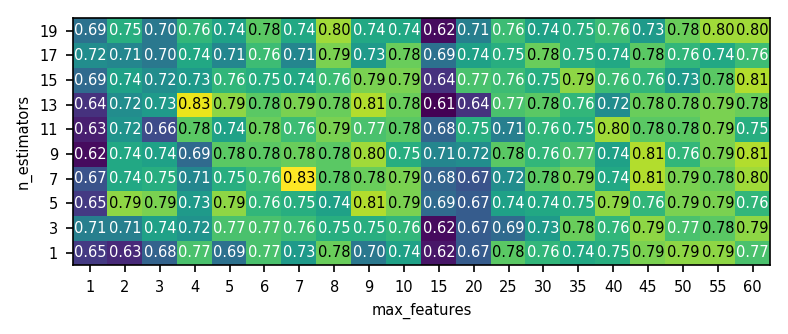

In [44]:
print("Test set score: {:.2f}".format(grid_search.score(X_test_scaled, y_test)))
grid_search_table_RF()

In [45]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(GridSearchCV(RandomForestClassifier(), param_grid, cv=3),
                         sonar_X, sonar_y, cv=10)
print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [ 0.45454545  0.71428571  0.66666667  0.57142857  0.57142857  0.76190476
  0.57142857  0.75        0.65        0.75      ]
Mean cross-validation score:  0.646168831169


**Ručni nested cross-validation**

In [77]:
param_grid = {'n_estimators': list(range(1,21,2)),
              'max_features': list(range(1,10))+list(range(10,61,5))}

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, random_state=2018)

X_train, X_test, y_train, y_test = [], [], [], []
# možda će ih trebati pretvoriti u numpy array kasnije, ne znam

for train_index, test_index in skf.split(X, y):
    X_train.append(X[train_index])
    X_test.append(X[test_index])
    y_train.append(y[train_index])
    y_test.append(y[test_index])
    
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=10)

rjecnik = {}
acc = []
for i in range(10):
        grid_search.fit(X_train[i], y_train[i])
        best_parameters = grid_search.best_estimator_.get_params()
        rjecnik[i+1] = (grid_search.best_score_, best_parameters['n_estimators'], best_parameters['max_features'])
        
        model = grid_search.best_estimator_.fit(X_train[i], y_train[i])
        '''y_pred = model.predict(X_test[i])
        acc_score = accuracy_score(y_test[i],y_pred)
        acc.append(acc_score)'''
        # može i ovako
        acc_score = model.score(X_test[i], y_test[i])
        acc.append(acc_score)
        
        rjecnik[i+1] = (grid_search.best_score_, best_parameters['n_estimators'], best_parameters['max_features'], acc_score)

In [78]:
print("Parametri dobiveni koristeći GridSearchCV:\n")
df = pd.DataFrame(rjecnik, index=['score', 'n_estimators', 'max_features', 'accuracy'])
print(df.round(2))

print(acc)
avg_accuracy = np.average(acc)
print("\nProsječna točnost k-NN-a s rbf kernelom i parametrima dobivenim koristeći GridSearchCV je:\n", 
      avg_accuracy*100, "%.")

Parametri dobiveni koristeći GridSearchCV:

                 1      2      3      4      5      6      7      8      9   \
score          0.83   0.84   0.86   0.87   0.84   0.85   0.83   0.84   0.82   
n_estimators  19.00  13.00  13.00  11.00  15.00  15.00  17.00  11.00  15.00   
max_features   2.00   3.00  15.00   2.00   9.00   6.00  45.00   7.00   8.00   
accuracy       0.86   0.71   0.67   0.62   0.71   0.81   0.86   0.90   0.90   

                 10  
score          0.85  
n_estimators  19.00  
max_features   7.00  
accuracy       0.70  
[0.86363636363636365, 0.7142857142857143, 0.66666666666666663, 0.61904761904761907, 0.7142857142857143, 0.80952380952380953, 0.8571428571428571, 0.90000000000000002, 0.90000000000000002, 0.69999999999999996]

Prosječna točnost k-NN-a s rbf kernelom i parametrima dobivenim koristeći GridSearchCV je:
 77.4458874459 %.
